## Import modules

In [1]:
from __future__ import division

import os; os.chdir(os.path.join('..', '..'))
print os.getcwd()

/Users/eharkin/Documents/School/Grad work/Thesis/Experiments/GIF fitting/GIF fitting project/GIFFittingToolbox


In [2]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.optimize as optimize

from analysis.gating.cell_class import Cell, Recording

In [3]:
max_normalize = lambda cell_channel: cell_channel / cell_channel.max(axis = 0)

def subtract_baseline(cell, baseline_range, channel):

    """
    Subtracts baseline from the selected channel of a Cell-like np.ndarray.

    Inputs:

    cell: Cell-like
    --  [c, t, s] array where c is channels, t is time (in timesteps), and s is sweeps

    baseline_range: slice
    --  Baseline time slice in timesteps

    channel: int
    --  Index of channel from which to subtract baseline. Not guaranteed to work with multiple channels.

    Returns:

        Copy of cell with baseline subtracted from the relevant channel.
    """

    cell = cell.copy()

    cell[channel, :, :] -= cell[channel, baseline_range, :].mean(axis = 0)

    return cell


def subtract_leak(cell, baseline_range, test_range, V_channel = 1, I_channel = 0):

    """
    Subtracts leak conductance from the I channel of a Cell-like np.ndarray.

    Calculates leak conductance based on Rm, which is extracted from test pulse.
    Assumes test pulse is the same in each sweep.

    Inputs:

        cell: Cell-like
        --  [c, t, s] array where c is channels, t is time (in timesteps), and s is sweeps

        baseline_range: slice
        --  baseline time slice in timesteps

        test_range: slice
        --  test pulse time slice in timesteps

        V_channel: int

        I_channel: int

    Returns:

        Leak-subtracted array.
    """

    Vtest_step = (
    cell[V_channel, baseline_range, :].mean(axis = 0)
    - cell[V_channel, test_range, :].mean(axis = 0)
    ).mean()
    Itest_step = (
    cell[I_channel, baseline_range, :].mean(axis = 0)
    - cell[I_channel, test_range, :].mean(axis = 0)
    ).mean()

    Rm = Vtest_step/Itest_step

    I_leak = (cell[V_channel, :, :] - cell[V_channel, baseline_range, :].mean()) / Rm

    leak_subtracted = cell.copy()
    leak_subtracted[I_channel, :, :] -= I_leak

    return leak_subtracted

## Load data

Results of a standard voltage step protocol are stored in ABF data files.

In [4]:
GATING_PATH = './data/gating/'

gating = Cell().read_ABF([GATING_PATH + '18411002.abf',
                          GATING_PATH + '18411010.abf',
                          GATING_PATH + '18411017.abf',
                          GATING_PATH + '18411019.abf',
                          GATING_PATH + 'c0_inact_18201021.abf',
                          GATING_PATH + 'c1_inact_18201029.abf',
                          GATING_PATH + 'c2_inact_18201034.abf',
                          GATING_PATH + 'c3_inact_18201039.abf',
                          GATING_PATH + 'c4_inact_18213011.abf',
                          GATING_PATH + 'c5_inact_18213017.abf',
                          GATING_PATH + 'c6_inact_18213020.abf',
                          GATING_PATH + '18619018.abf',
                          GATING_PATH + '18614032.abf'])

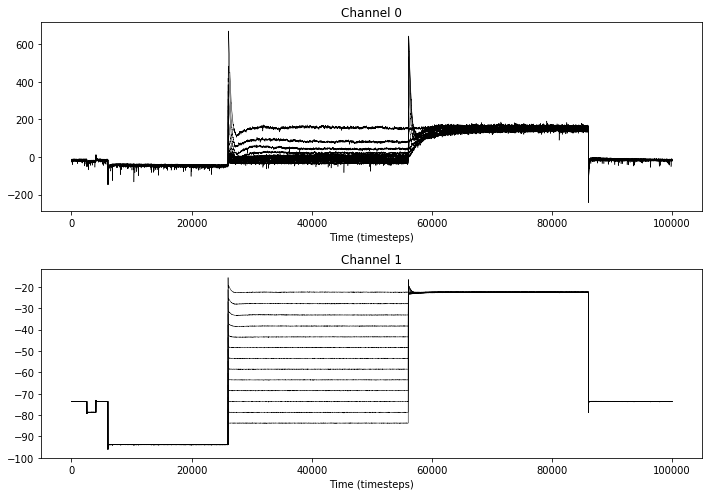

In [5]:
gating[0].plot()

## Inspect voltage steps (unprocessed recordings)

Depolarization-activated currents vary between cells. Plot a summary.

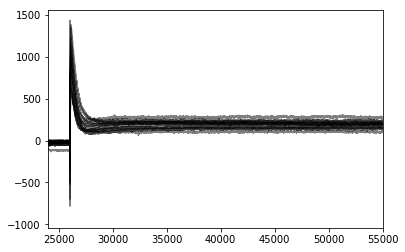

In [19]:
plt.figure()

plt.subplot(111)

for i, rec in enumerate(gating):
    plt.plot(rec[0, :, -1], 'k-', alpha = 0.5)

plt.xlim(24000, 55000)
plt.show()

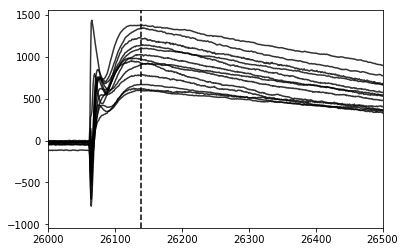

In [23]:
t_peak = 26140

plt.figure()

plt.subplot(111)

for i, rec in enumerate(gating):
    plt.plot(rec[0, :, -1], 'k-', alpha = 0.8)
    
plt.axvline(t_peak, color = 'k', ls = '--')
plt.xlim(26000, 26500)
plt.show()

## Process recordings

Subtract baseline and leak.

In [34]:
processed = []

for i, rec in enumerate(gating):
    tmp = subtract_baseline(rec, slice(1000, 2000), 0)
    tmp = subtract_leak(rec, slice(1000, 2000), slice(3000, 3400))
    #tmp /= tmp[0, t_peak, -1] # Normalize amplitude.
    processed.append(tmp)

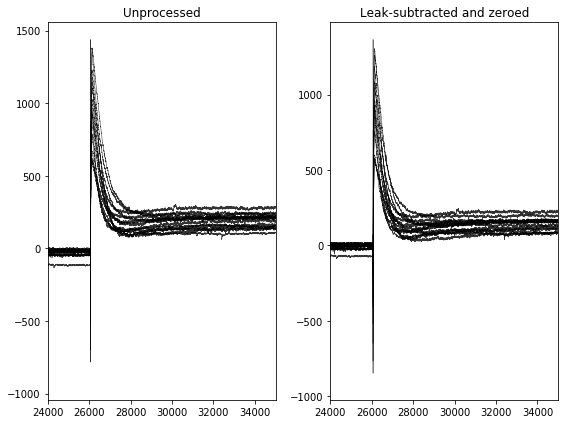

In [36]:
plt.figure(figsize = (8, 6))

ax_raw = plt.subplot(121)
ax_raw.set_title('Unprocessed')
ax_processed = plt.subplot(122)
ax_processed.set_title('Leak-subtracted and zeroed')

for raw_, proc_ in zip(gating, processed):
    
    ax_raw.plot(raw_[0, :, -1], 'k-', lw = 0.5, alpha = 0.8)
    ax_processed.plot(proc_[0, :, -1], 'k-', lw = 0.5, alpha = 0.8)
    
    
ax_raw.set_xlim(24000, 35000)
ax_processed.set_xlim(24000, 35000)

plt.tight_layout()

plt.show()

## Summary plots

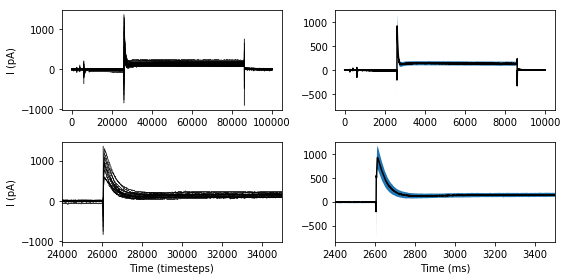

In [50]:
IMG_PATH = os.path.join('figs', 'ims', 'gating')

traces = np.array([x[0, :, -1] for x in processed]).T

plt.figure(figsize = (8, 4))

plt.subplot(221)
plt.plot(traces, 'k-', lw = 0.5, alpha = 0.8)
plt.ylabel('I (pA)')

plt.subplot(222)
plt.fill_between(
        x = np.arange(0, traces.shape[0] * 0.1, 0.1), 
    y1 = traces.mean(axis = 1) - traces.std(axis = 1), 
    y2 = traces.mean(axis = 1) + traces.std(axis = 1)
)
plt.plot(np.arange(0, traces.shape[0] * 0.1, 0.1), traces.mean(axis = 1), 'k-')

plt.subplot(223)
plt.plot(traces, 'k-', lw = 0.5, alpha = 0.8)
plt.xlim(24000, 35000)
plt.xlabel('Time (timesteps)')
plt.ylabel('I (pA)')

plt.subplot(224)
plt.fill_between(
    x = np.arange(0, traces.shape[0] * 0.1, 0.1), 
    y1 = traces.mean(axis = 1) - traces.std(axis = 1), 
    y2 = traces.mean(axis = 1) + traces.std(axis = 1)
)
plt.plot(np.arange(0, traces.shape[0] * 0.1, 0.1), traces.mean(axis = 1), 'k-')
plt.xlim(2400, 3500)
plt.xlabel('Time (ms)')

plt.tight_layout()

if IMG_PATH is not None:
    plt.savefig(os.path.join(IMG_PATH, 'gating_summary.png'), dpi = 300)

plt.show()